# Image Retrieval using Autoencoders (PyTorch)

In [1]:
import time
import copy
import pickle
from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt #for plotting
from sklearn.model_selection import train_test_split #ML library
from PIL import Image
import cv2
%matplotlib inline

import torch #DL library
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0

import os

First, let's identify whether we have GPU or CPU on our device


In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# image = plt.imread('bass_0028.jpg')
# fig, ax = plt.subplots()
# ax.imshow(image)
# print(image.shape)
# image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
# print(image.shape)
# compose = transforms.Compose([transforms.ToTensor(), 
#                               transforms.Resize((128, 128), interpolation = Image.BICUBIC)])

# a_trans = compose(image)
# print(a_trans.shape)

<b> Data extraction </b>

Then we have to extract images from our folder and convert it to Pandas dataframe

In [4]:
datasetPath = Path('.../dataset/')
df = pd.DataFrame()
    
df['image'] = [f for f in os.listdir(datasetPath) if os.path.isfile(os.path.join(datasetPath, f))]
df['image'] = '.../dataset/' + df['image'].astype(str)
df.head()

,image
0,/Users/nurdauletzhuzbay/Desktop/image_retrieva...
1,/Users/nurdauletzhuzbay/Desktop/image_retrieva...
2,/Users/nurdauletzhuzbay/Desktop/image_retrieva...
3,/Users/nurdauletzhuzbay/Desktop/image_retrieva...
4,/Users/nurdauletzhuzbay/Desktop/image_retrieva...


<b> Data pre-processing </b>

First, we have to convert PIL Images to tensors. Then, we applied resizing of images to have all training examples of the same size (Interpolation is Bicubic). Then, we applied normalization std_dev = 5 and mean = 5, to make max and min values between 1 and -1, respectively. Also, we shouldn't forget to check if an input image is grayscale or rgb, if it is in grayscale we have to convert it to RGB.  


In [9]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128, 128), interpolation = Image.BICUBIC),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            
        ])
    
    def __getitem__(self, key):
       
        row = self.dataFrame.iloc[key]
        image = self.transformations(Image.open(row['image']).convert('RGB'))
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)

In this cell, we divide our dataset to train and validation sets. test_size is chosen to be 0.2. random_state = 0. 

In [15]:
# Intermediate Function to process data from the data retrival class
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.2, random_state=RANDOMSTATE)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    
    return train_set, validate_set

Building neural nets of our autoencoder. We built 7 encoder and 7 decoder layers. As activation function we used rectifying linera unit (ReLU). It is very important to note that input tensor dimensions should match with the output tensor dimensions. 

In [10]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size = 2, stride=2), 
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=0), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2) 
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1,
                              padding=1), 
 
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1, 
                               padding=1),  
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=0),  
            
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1), 
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=3, 
                               kernel_size=(4,4), 
                               stride=2, 
                               padding=2),  
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



Below we can see the summary of our neural net. We have 3,313,731 trainable parameters. 

In [11]:
summary(ConvAutoencoder().to(device),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 126, 126]         147,584
              ReLU-9        [-1, 128, 126, 126]               0
        MaxPool2d-10          [-1, 128, 63, 63]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

Now, we have to initialize state_dict to save and load our checkpoints. As an optimizer we chose Adam optimizer and as loss criterion mean squared error (MSE Loss).  


In [16]:
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint
    
def train_model(model,  
                criterion, 
                optimizer, 
                num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # k-fold validation step
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # training
            else:
                model.eval()   # validation

            running_loss = 0.0

            # Iterate over data.
            for i, inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # applying backward and optimizing only if in train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='ckpt_epoch_{}.pt'.format(epoch))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

Now only thing left is to prepare our environment


In [17]:
EPOCHS = 30
NUM_BATCHES = 40
RETRAIN = False

train_set, validate_set = prepare_data(DF=df)

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=0) ,
                'val':DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=0)
                }


dataset_sizes = {'train': len(train_set),'val':len(validate_set)}


model = ConvAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(



Training our model



In [18]:

model, optimizer, loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    num_epochs=EPOCHS)

Epoch 0/30
----------
  40/5151: [>...............................] - ETA 0.0s

KeyboardInterrupt: 

In [19]:
# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'conv_autoencoder.pt')

NameError: name 'loss' is not defined

In [22]:
transformations = transforms.Compose([transforms.ToTensor(),
            transforms.Resize((128,128),interpolation=Image.NEAREST),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))            
        ])

In [23]:
#Load Model in Evaluation phase
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load('/Users/nurdauletzhuzbay/Desktop/image_retrieval_code/conv_autoencoder.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

<b> Extracting Latent Features </b>

Change 6439 according to the length of latent features. In this case it is 6439.

In [24]:
def get_latent_features(images, transformations):
    
    latent_features = np.zeros((6439,256,4,4))
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image).convert('RGB')).to(device)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [25]:
images = df.image.values
latent_features = get_latent_features(images, transformations)

100%|██████████| 6439/6439 [04:19<00:00, 24.78it/s]



Map the indices and latent features in a dictionary. 

In [26]:
indexes = list(range(0, 6439))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [27]:
def euclidean(a, b):
    # euclidean distance between two vectors
    return np.linalg.norm(a - b)

Similarity search between query image and images in the database. Compute the euclidean distance between our query features and the features for the current image in our index, then update our results list with a 2-tuple consisting of the computed distance and the index of the image


In [28]:
def perform_search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])):
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results
    results = sorted(results)[:maxResults]

    return results

In [29]:
def build_montages(image_list, image_shape, montage_shape):

    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

In [30]:
testpath = Path('/Users/nurdauletzhuzbay/Desktop/image_retrieval_code/test')
testdf = pd.DataFrame()

testdf['image'] = [f for f in os.listdir(testpath) if os.path.isfile(os.path.join(testpath, f))]
testdf['image'] = '/Users/nurdauletzhuzbay/Desktop/image_retrieval_code/test/' + testdf['image'].astype(str)

testdf

,image
0,/Users/nurdauletzhuzbay/Desktop/image_retrieva...
1,/Users/nurdauletzhuzbay/Desktop/image_retrieva...
2,/Users/nurdauletzhuzbay/Desktop/image_retrieva...
3,/Users/nurdauletzhuzbay/Desktop/image_retrieva...


In [31]:
testimages = testdf.image.values
test_latent_features = get_latent_features(testimages, transformations)
test_latent_features.shape

100%|██████████| 4/4 [00:00<00:00, 20.56it/s]


(6439, 256, 4, 4)

Set MAX_RESULTS to whatever you like, how many similar images you want to be displayed. queryIdx is the index of desired test image in a test_dataset. 


3631
1088
3580
2943
2118


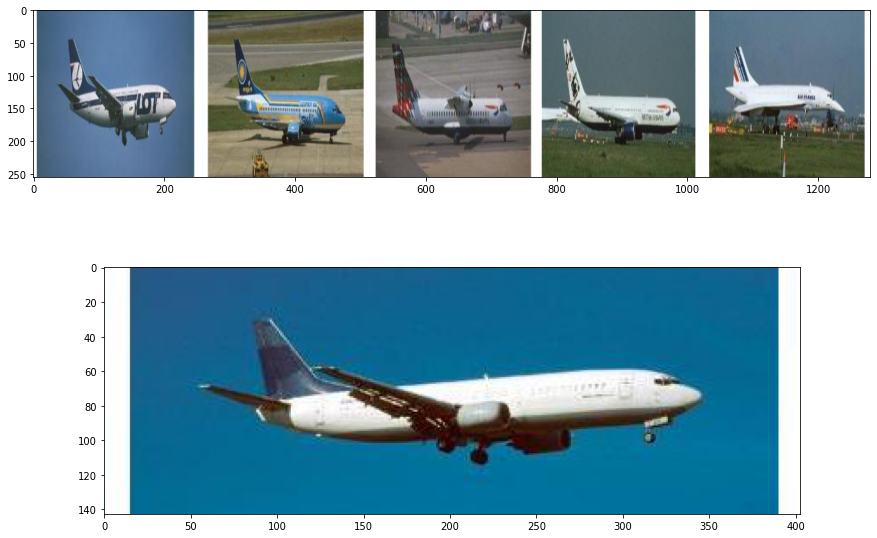

In [32]:
fig, ax = plt.subplots(nrows=2,figsize=(15,10))
MAX_RESULTS = 5
queryIdx = 0


queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j)
    imgs.append(img)

# display the query image
ax[1].imshow(np.array(Image.open(testimages[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (256, 256), (5, 1))[0]
ax[0].imshow(montage)

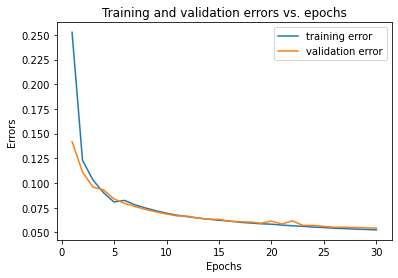

In [20]:
x = list(range(1, 31))

train_err = [0.2527, 0.1229, 0.1030, 0.0902, 0.0808, 0.0824, 0.0779, 0.0747, 0.0719, 0.0694, 0.0674, 0.0659, 0.0645, 0.0633, 
            0.0623, 0.0615, 0.0602, 0.0595, 0.0587, 0.0583, 0.0574, 0.0567, 0.0561, 0.0554, 0.0549, 0.0542, 0.0538, 0.0533, 0.053, 0.0525]

val_err = [0.1419, 0.1111, 0.0958, 0.0931, 0.0839, 0.0794, 0.0762, 0.0733, 0.0708, 0.0686, 0.0667, 0.0664, 0.0645, 0.0634,
          0.0632, 0.0613, 0.0607, 0.0605, 0.0593, 0.0614, 0.0585, 0.0617, 0.0571, 0.0570, 0.0561, 0.0552, 0.0552, 0.0549, 0.0546, 0.0543]

len(val_err)

plt.plot(x, train_err, label = "training error")
plt.plot(x, val_err, label = "validation error")
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Training and validation errors vs. epochs')
plt.legend()
plt.show()